## 1. Import Libraries 


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

## 2. Load Dataset

In [1]:
electricity_data = pd.read_csv(
    "C:/Users/AYDIN/Documents/Electricity load dataset.txt",
    sep=";",
    decimal=",",
    engine="python",
    parse_dates=[0],    
    index_col=0,        
    nrows=140256
)


In [2]:
electricity_data.index.min(), electricity_data.index.max()


(Timestamp('2011-01-01 00:15:00'), Timestamp('2015-01-01 00:00:00'))

In [3]:
electricity_data = electricity_data[['MT_001']]
electricity_data.rename(columns={'MT_001': 'load'}, inplace=True)


## 3. Data Overview

In [4]:
electricity_data.head()


,load
2011-01-01 00:15:00,0.0
2011-01-01 00:30:00,0.0
2011-01-01 00:45:00,0.0
2011-01-01 01:00:00,0.0
2011-01-01 01:15:00,0.0


## Exploratory Data Analysis

In [5]:
electricity_data.tail(10)

,load
2014-12-31 21:45:00,2.538071
2014-12-31 22:00:00,1.269036
2014-12-31 22:15:00,2.538071
2014-12-31 22:30:00,2.538071
2014-12-31 22:45:00,1.269036
2014-12-31 23:00:00,2.538071
2014-12-31 23:15:00,2.538071
2014-12-31 23:30:00,2.538071
2014-12-31 23:45:00,1.269036
2015-01-01 00:00:00,2.538071


In [6]:
electricity_data['load'].describe()

count    140256.000000
mean          3.970785
std           5.983965
min           0.000000
25%           0.000000
50%           1.269036
75%           2.538071
max          48.223350
Name: load, dtype: float64

In [7]:
electricity_data = electricity_data[electricity_data['load'] > 0]


In [8]:
electricity_data.shape

(99513, 1)

<Axes: title={'center': 'Electricity Usage After Cleaning'}>

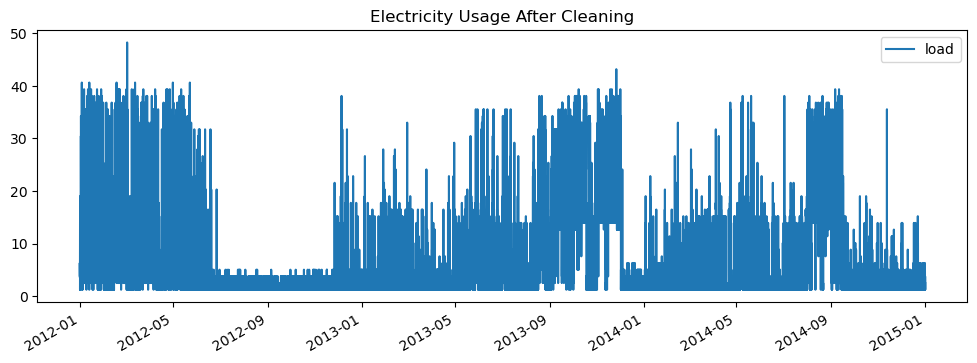

In [9]:
electricity_data.plot(figsize=(12,4), title="Electricity Usage After Cleaning")


In [ ]:
## 5. Feature Engineering

In [10]:
electricity_data['hour'] = electricity_data.index.hour
electricity_data['dayofweek'] = electricity_data.index.dayofweek

In [11]:
electricity_data.head()


,load,hour,dayofweek
2012-01-01 00:15:00,3.807107,0,6
2012-01-01 00:30:00,5.076142,0,6
2012-01-01 00:45:00,3.807107,0,6
2012-01-01 01:00:00,3.807107,1,6
2012-01-01 01:15:00,5.076142,1,6


In [12]:
electricity_data['minute'] = electricity_data.index.minute


In [13]:
electricity_data.head()


,load,hour,dayofweek,minute
2012-01-01 00:15:00,3.807107,0,6,15
2012-01-01 00:30:00,5.076142,0,6,30
2012-01-01 00:45:00,3.807107,0,6,45
2012-01-01 01:00:00,3.807107,1,6,0
2012-01-01 01:15:00,5.076142,1,6,15


In [14]:
features = ['load', 'hour', 'minute', 'dayofweek']
data = electricity_data[features]

In [15]:
print(data.shape)
print(data.head())


(99513, 4)
                         load  hour  minute  dayofweek
2012-01-01 00:15:00  3.807107     0      15          6
2012-01-01 00:30:00  5.076142     0      30          6
2012-01-01 00:45:00  3.807107     0      45          6
2012-01-01 01:00:00  3.807107     1       0          6
2012-01-01 01:15:00  5.076142     1      15          6


In [16]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)


In [17]:
scaled_data.shape


(99513, 4)

In [18]:
electricity_data.index = pd.to_datetime(electricity_data.index)

electricity_data.index.min(), electricity_data.index.max()


(Timestamp('2012-01-01 00:15:00'), Timestamp('2015-01-01 00:00:00'))

In [19]:
electricity_data.index.inferred_freq


In [20]:
(electricity_data["load"] == 0).sum()


0

In [21]:
df = electricity_data.copy()

df["hour"] = df.index.hour
df["minute"] = df.index.minute
df["dayofweek"] = df.index.dayofweek
df["is_weekend"] = (df["dayofweek"] >= 5).astype(int)


In [22]:
df["lag_1"] = df["load"].shift(1)       
df["lag_4"] = df["load"].shift(4)      
df["lag_96"] = df["load"].shift(96)     


In [23]:
df["rolling_mean_1h"] = df["load"].rolling(4).mean()
df["rolling_mean_24h"] = df["load"].rolling(96).mean()


In [24]:
df.dropna(inplace=True)


## 6. Train-Test Split

In [25]:
train_size = int(len(df) * 0.8)

train = df.iloc[:train_size]
test = df.iloc[train_size:]


In [26]:
X_train = train.drop("load", axis=1)
y_train = train["load"]

X_test = test.drop("load", axis=1)
y_test = test["load"]


## 7. Model Training

In [27]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

preds = model.predict(X_test)


In [28]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(y_test, preds)
print("MAE:", mae)


MAE: 0.9374567473681813


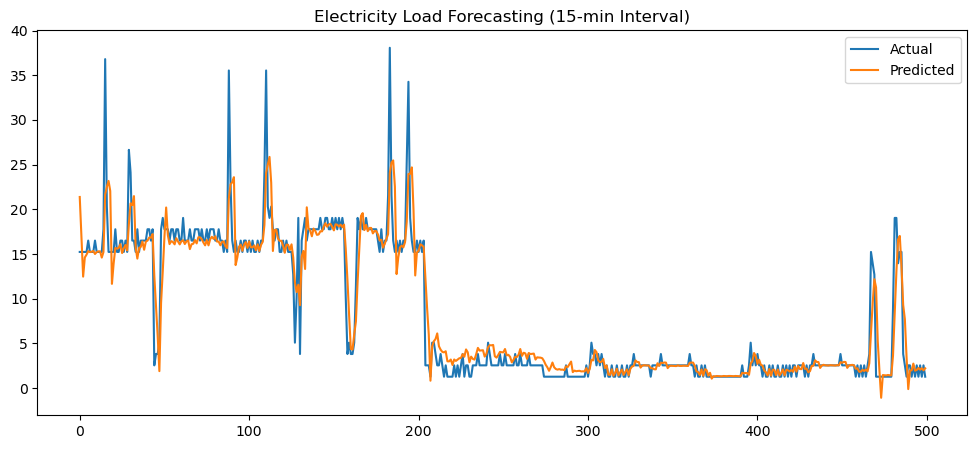

In [29]:
plt.figure(figsize=(12,5))
plt.plot(y_test.values[:500], label="Actual")
plt.plot(preds[:500], label="Predicted")
plt.legend()
plt.title("Electricity Load Forecasting (15-min Interval)")
plt.show()


In [30]:
features = df.drop("load", axis=1).values
target = df["load"].values


In [31]:
def create_sequences(X, y, input_steps=96, output_steps=16):
    X_seq, y_seq = [], []
    
    for i in range(len(X) - input_steps - output_steps):
        X_seq.append(X[i : i + input_steps])
        y_seq.append(y[i + input_steps : i + input_steps + output_steps])
    
    return np.array(X_seq), np.array(y_seq)


In [32]:
import numpy as np


In [33]:
X_seq, y_seq = create_sequences(
    features,
    target,
    input_steps=96,
    output_steps=16
)


In [34]:
X_seq.shape, y_seq.shape


((99305, 96, 9), (99305, 16))

In [35]:
split_idx = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:split_idx], X_seq[split_idx:]
y_train, y_test = y_seq[:split_idx], y_seq[split_idx:]


In [36]:
from sklearn.preprocessing import MinMaxScaler

feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_reshaped = X_train.reshape(-1, X_train.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = feature_scaler.fit_transform(X_train_reshaped).reshape(X_train.shape)
X_test_scaled = feature_scaler.transform(X_test_reshaped).reshape(X_test.shape)

y_train_scaled = target_scaler.fit_transform(y_train)
y_test_scaled = target_scaler.transform(y_test)


In [37]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


C:\Users\AYDIN\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


In [38]:
import tensorflow as tf
tf.__version__


'2.20.0'

In [39]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


In [40]:
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train_scaled.shape[1],
                                                  X_train_scaled.shape[2])),
    Dropout(0.2),
    
    LSTM(32),
    Dropout(0.2),
    
    Dense(y_train_scaled.shape[1])  # 16-step output
])


C:\Users\AYDIN\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [41]:
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse"
)


In [42]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)


In [43]:
history = model.fit(
    X_train_scaled,
    y_train_scaled,
    validation_split=0.1,
    epochs=50,
    batch_size=32,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 111s 48ms/step - loss: 0.0076 - val_loss: 0.0038
Epoch 2/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - loss: 0.0068 - val_loss: 0.0036
Epoch 3/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - loss: 0.0065 - val_loss: 0.0033
Epoch 4/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 108s 48ms/step - loss: 0.0063 - val_loss: 0.0033
Epoch 5/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - loss: 0.0061 - val_loss: 0.0033
Epoch 6/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 108s 48ms/step - loss: 0.0060 - val_loss: 0.0031
Epoch 7/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 111s 50ms/step - loss: 0.0058 - val_loss: 0.0033
Epoch 8/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 109s 49ms/step - loss: 0.0057 - val_loss: 0.0033
Epoch 9/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 107s 48ms/step - loss: 0.0056 - val_loss: 0.0032
Epoch 10/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 106s 48ms/step - loss: 0.0054 - val_loss: 0.0033
Epoch 11/50
2235/2235 ━━━━━━━━━━━━━━━━━━━━ 108s 48ms/step - loss: 0.0053 - val_loss: 0.00

In [ ]:
## 8. Evaluation

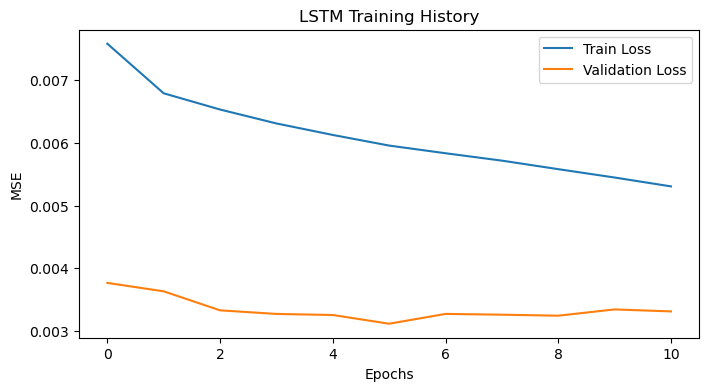

In [44]:
plt.figure(figsize=(8,4))
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.title("LSTM Training History")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.show()


In [45]:
y_pred_scaled = model.predict(X_test_scaled)


621/621 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step


In [46]:
y_pred_scaled.shape


(19861, 16)

In [47]:
y_pred = target_scaler.inverse_transform(y_pred_scaled)
y_true = target_scaler.inverse_transform(y_test_scaled)


In [48]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

rmse = np.sqrt(mean_squared_error(y_true.flatten(), y_pred.flatten()))
mae = mean_absolute_error(y_true.flatten(), y_pred.flatten())
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100

rmse, mae, mape


(3.346606831511742, 1.6899861485319032, 62.21940961037753)

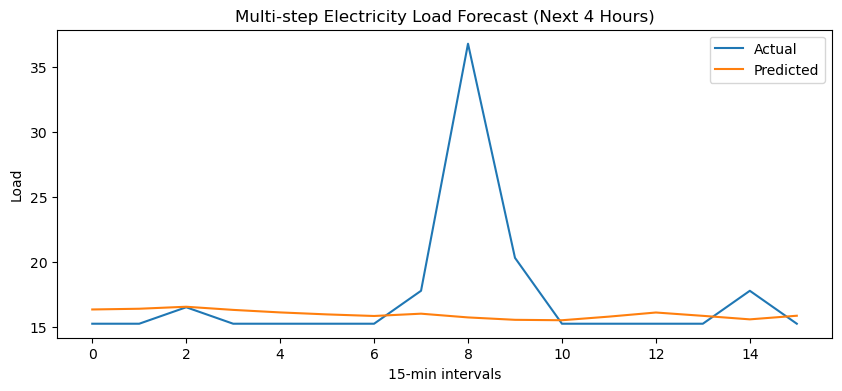

In [49]:
plt.figure(figsize=(10,4))
plt.plot(y_true[0], label="Actual")
plt.plot(y_pred[0], label="Predicted")
plt.legend()
plt.title("Multi-step Electricity Load Forecast (Next 4 Hours)")
plt.xlabel("15-min intervals")
plt.ylabel("Load")
plt.show()


In [50]:
train_load = df.iloc[:train_size]["load"]
test_load  = df.iloc[train_size:]["load"]


In [51]:
from statsmodels.tsa.statespace.sarimax import SARIMAX


In [52]:
electricity_load_dataset = electricity_data.asfreq("15min")


In [53]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# taking a small subset to test
y = electricity_data["load"].iloc[:2000]

model = SARIMAX(
    y,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 96),  # 15-minute data - 96 steps per day
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)
print("Model fitted successfully")


C:\Users\AYDIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)
C:\Users\AYDIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency 15min will be used.
  self._init_dates(dates, freq)


Model fitted successfully


In [54]:
# 30 days of 15-min data
window_size = 96 * 30  

train_load_small = train_load[-window_size:]
test_load_small  = test_load[:window_size]


In [55]:
train_load_small = train_load_small.asfreq("15min")
test_load_small  = test_load_small.asfreq("15min")


In [56]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

sarimax_model = SARIMAX(
    train_load_small,
    order=(1, 1, 1),
    seasonal_order=(0, 1, 0, 96),
    enforce_stationarity=False,
    enforce_invertibility=False
)

sarimax_result = sarimax_model.fit(disp=False)


In [58]:
# Aligning indexes
sarimax_forecast = sarimax_forecast.reindex(test_load_small.index)

# Droping NaNs from both
mask = (~test_load_small.isna()) & (~sarimax_forecast.isna())

test_clean = test_load_small[mask]
forecast_clean = sarimax_forecast[mask]


NameError: name 'sarimax_forecast' is not defined

In [57]:
test_load_small.isna().sum(), sarimax_forecast.isna().sum()


NameError: name 'sarimax_forecast' is not defined

In [ ]:
rmse_sarimax = np.sqrt(mean_squared_error(test_clean, forecast_clean))
mae_sarimax  = mean_absolute_error(test_clean, forecast_clean)
mape_sarimax = np.mean(np.abs(
    (test_clean - forecast_clean) / test_clean
)) * 100

rmse_sarimax, mae_sarimax, mape_sarimax


In [ ]:
plt.figure(figsize=(12,4))
plt.plot(test_load_small.values, label="Actual")
plt.plot(sarimax_forecast.values, label="SARIMAX Forecast")
plt.legend()
plt.title("SARIMAX Baseline (30-Day Window)")
plt.show()


In [ ]:
results.summary()
X_test_scaled.shape


In [ ]:
# Ensure datetime index
electricity_data.index = pd.to_datetime(electricity_data.index)

# Resample to hourly
hourly_load = electricity_data.resample("1H").mean()

# Optional: remove missing values
hourly_load = hourly_load.dropna()


In [ ]:
train_size = int(len(hourly_load) * 0.8)
train = hourly_load.iloc[:train_size]
test = hourly_load.iloc[train_size:]


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train,
    order=(1,1,1),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


In [ ]:
y = hourly_load["load"]  


In [ ]:
train_size = int(len(y) * 0.8)
train = y.iloc[:train_size]
test = y.iloc[train_size:]


In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    train,
    order=(1,0,1),
    seasonal_order=(1,0,1,24),
    enforce_stationarity=False,
    enforce_invertibility=False
)

results = model.fit(disp=False)


In [ ]:
# Forecast
forecast = results.get_forecast(steps=len(test))
forecast_mean = forecast.predicted_mean


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

mae = mean_absolute_error(test, forecast_mean)
rmse = np.sqrt(mean_squared_error(test, forecast_mean))

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")


In [ ]:
plt.figure(figsize=(12,5))

plt.plot(
    test.index[-500:], 
    test[-500:], 
    label="Actual"
)

plt.plot(
    test.index[-500:], 
    forecast_mean[-500:], 
    label="SARIMAX Forecast"
)

plt.legend()
plt.title("Electricity Load Forecast – SARIMAX (Hourly)")
plt.xlabel("Time")
plt.ylabel("Load")
plt.show()
